In [44]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Process the data and convert it into a pandas DataFrame
data = []
with open("frame_data.txt", "r") as file:
    for line in file:
        values = line.strip().split()
        frame = float(values[0])
        pedestrian_id = float(values[1])
        x = float(values[-4])
        y = float(values[-2])
        data.append([frame, pedestrian_id, x, y])

df = pd.DataFrame(data, columns=["frame", "pedestrian_id", "x", "y"])

In [46]:
# add a new pid 0 to each frame in df with x,y = 0,0 representing the center of the frame
center = pd.DataFrame([[frame, 0, 0, 0] for frame in df["frame"].unique()], columns=["frame", "pedestrian_id", "x", "y"])
df = pd.concat([df, center])

In [47]:
# CREATE VIDEO USING OUR VIDEO FRAMES
import os
import cv2
# Set the path to the directory containing the images
image_dir = 'parallel'
# Get the sorted list of image files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])
# every image is in format 'color{frame}.jpg'
# reorder the image files to match the order of the frames in the dataframe
# create dictionary of frame number to image file
image_files = {int(f.split('color')[1].split('.')[0])-1: f for f in image_files}

# Create a video writer to save the video frames
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
first_image = cv2.imread(os.path.join(image_dir, image_files[0]))
video_writer = cv2.VideoWriter('video.mp4', fourcc, 10, (first_image.shape[1], first_image.shape[0]))

# Write the video frames to the video writer
for frame in df['frame'].unique():
    image_file = image_files[frame]
    img = cv2.imread(os.path.join(image_dir, image_file))
    video_writer.write(img)

video_writer.release()

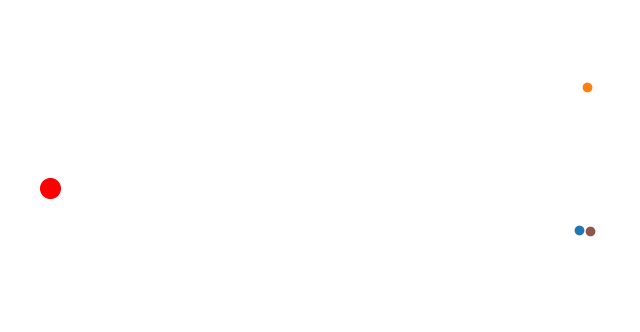

In [50]:
# CREATE TOP DOWN VISUALIZATIONS OF THE TRAJECTORIES AND SAVE AS GIF
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


# Create a figure and axis for the trajectory plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(df['x'].min()-1, df['x'].max()+1)
ax.set_ylim(df['y'].min()-1, df['y'].max()+1)
ax.set_aspect('equal')
ax.axis('off')

# Create empty lists to store the scatter plots
scatters = []

# Add a large point at (0, 0)
origin_point = ax.scatter(0, 0, s=200, color='red', marker='o', zorder=3)
scatters.append(origin_point)

# Initialize the scatter plots for each pedestrian_id
for pid in df['pedestrian_id'].unique():
    scat = ax.scatter([], [], label=f'Pedestrian {int(pid)}')
    scatters.append(scat)

# Update function for the animation
def update(frame):
    # Update the trajectory plot
    for scat, pid in zip(scatters[1:], df['pedestrian_id'].unique()):
        mask = (df['frame'] == frame) & (df['pedestrian_id'] == pid)
        scat.set_offsets(df.loc[mask, ['x', 'y']].values)
    
    # # Display the corresponding image
    # if frame < len(image_files):
    #     img = cv2.imread(os.path.join(image_dir, image_files[frame]))
    #     ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #     ax2.axis('off')

    
    # # Save the current frame as an image
    # plt.savefig(f'end_results/combined_frame_{int(frame)}.png', bbox_inches='tight')
    
    return scatters

# Create the animation
ani = FuncAnimation(fig, update, frames=df['frame'].unique(), blit=True, interval=100)

# Save the animation as a video file using PillowWriter
writer = PillowWriter(fps=10)
ani.save("trajectory_animation.gif", writer=writer)
# Close the video window

In [51]:
# COMBINE THE GIF AND VIDEO INTO A SINGLE VIDEO
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Read the trajectory animation GIF
gif = cv2.VideoCapture('trajectory_animation.gif')

# Get the video frames
video = cv2.VideoCapture('video.mp4')

# Get the video frame size
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a video writer for the combined video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
combined_writer = cv2.VideoWriter('combined_video.mp4', fourcc, 10, (video_width * 2, video_height))

while True:
    # Read frames from the GIF and video
    ret_gif, frame_gif = gif.read()
    ret_video, frame_video = video.read()

    if not ret_gif or not ret_video:
        break

    # Resize the GIF frame to match the video frame size
    frame_gif = cv2.resize(frame_gif, (video_width, video_height))

    # Combine the GIF and video frames side by side
    combined_frame = np.concatenate((frame_gif, frame_video), axis=1)

    # Write the combined frame to the video writer
    combined_writer.write(combined_frame)

# Release the video capture and writer objects
gif.release()
video.release()
combined_writer.release()